In [1]:
import numpy as np
import scanpy as sc
import scvi
from matplotlib import pyplot as plt

Global seed set to 0


In [2]:
path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [3]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key="modality")

vae = scvi.model.MULTIVI(adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum())
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:385: LightningDeprecationWarning: The `Callback.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_<train/validation/test>_epoch_end` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/module/_multivae.py:557: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  x = torch.where(mask_expr.T, x_expr.T, x_acc.T).T


Epoch 78/500:  15%|█▌        | 77/500 [07:37<45:04,  6.39s/it, loss=7.47e+03, v_num=1]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
vae.save("Hair_Multivi")

In [2]:
adata = sc.read_h5ad("data/datasets/mouse_hair_multi_omics.h5ad")


In [3]:
adata

AnnData object with n_obs × n_vars = 6436 × 113615
    obs: 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'chromepot', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'epxr_latent_10', 'epxr_latent_11', 'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15', 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 'atac_latent_11', 'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19'
    var: 'feature_types', 'modality', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap'
    obsm: 'X_mvi', 'X_scMVP', 'X_

In [6]:
latent = vae.get_latent_representation()
adata.obsm["X_mvi"] = latent

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


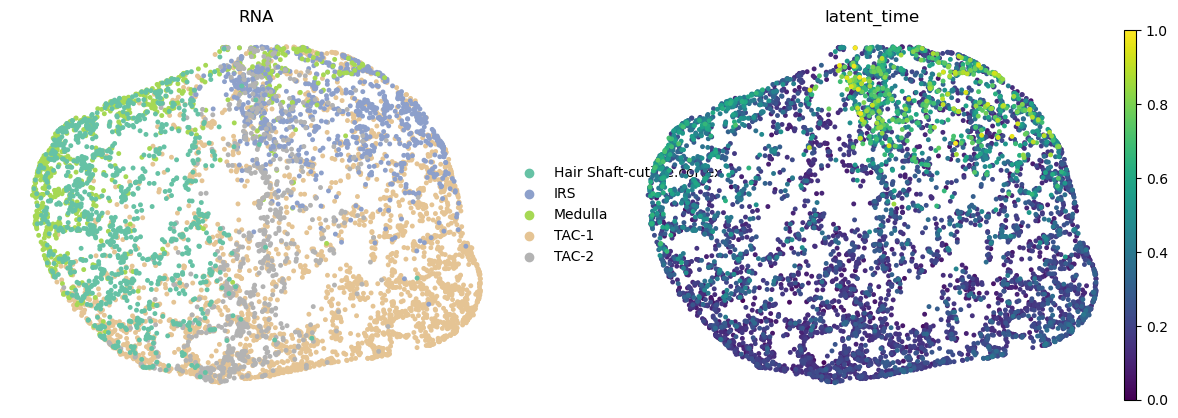

In [12]:
sc.pp.neighbors(adata, use_rep = 'X_mvi',n_neighbors=30, metric = 'manhattan')
sc.tl.umap(adata, min_dist=0.5, negative_sample_rate=0.1, spread=10)
sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=['celltype', "latent_time"], title="RNA",palette="Set2")

In [7]:
adata.write_h5ad("data/datasets/mouse_hair_multi_omics.h5ad")

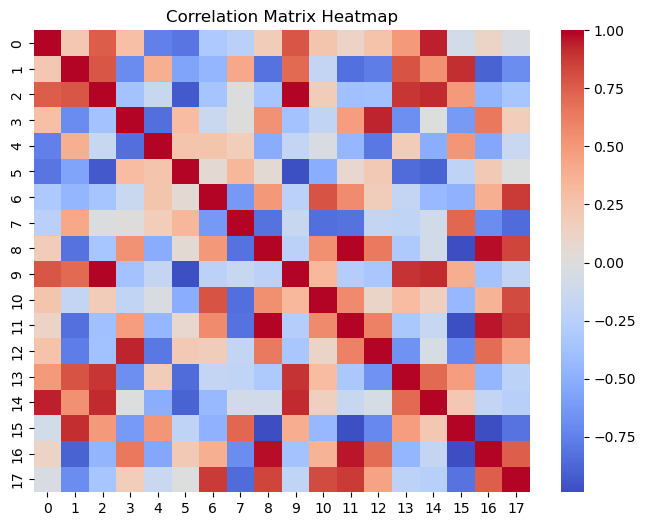

In [13]:
import pandas as pd
import seaborn as sns
df_combined = pd.DataFrame(latent)
correlation_matrix = df_combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", center=0.0)
plt.title('Correlation Matrix Heatmap')
plt.show()

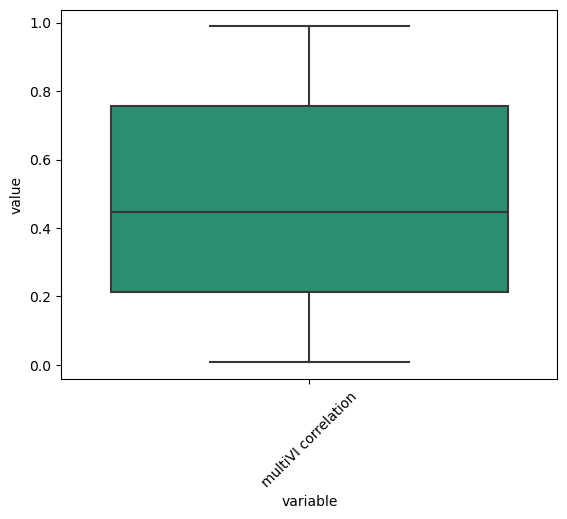

In [15]:
correlation_matrix = np.abs(correlation_matrix)
lower_triangular_matrix = np.tril(correlation_matrix, k=-1)
lower_diagonal_values = lower_triangular_matrix[lower_triangular_matrix != 0]
df = pd.DataFrame({"variable": "multiVI correlation", "value": lower_diagonal_values})
ax = sns.boxplot(x='variable', y='value', data=df, palette="Dark2")
plt.xticks(rotation=45)
plt.savefig("corr_multiVI_hair.pdf", dpi=300)

In [16]:
df.to_csv("hair_corr_multiVI.csv")

(6436, 18)
6


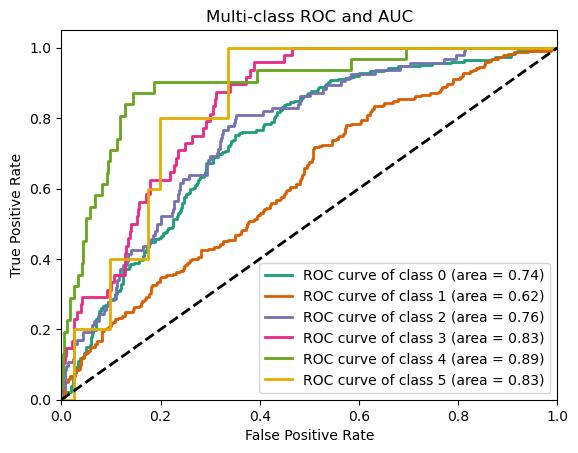

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc


X = latent
print(X.shape)
# adata_mvi.obs["latent_time_50"] = pd.cut(adata_mvi.obs['latent_time'], 50, labels=[i for i in range(50)])
# adata_mvi.obs["latent_time_10"] = pd.cut(adata_mvi.obs['latent_time'], 10, labels=[i for i in range(10)])
# adata_mvi.obs["latent_time_5"] = pd.cut(adata_mvi.obs['latent_time'], 5, labels=[i for i in range(5)])
# adata_mvi.obs["latent_time_8"] = pd.cut(adata_mvi.obs['latent_time'], 8, labels=[str(i) for i in range(8)])
# adata_mvi.obs["latent_time_6"] = pd.cut(adata_mvi.obs['latent_time'], 6, labels=[str(i) for i in range(6)])
bins = 6
y = pd.cut(adata.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
roc_df = pd.DataFrame({"fpr":fpr, "tpr": tpr, "roc_auc":roc_auc, "methods": "rna_atac_multivi"})
plt.savefig("figs/Hair/20_aligned/multivi_roc.pdf", dpi=300)


In [21]:
roc_df.to_csv("hair_multiVI_roc.csv")

In [9]:
## benchmark OT
import ot
import ot.plot

adata_multi_ini  = adata[adata.obs['celltype'].isin( ['TAC-1', 'TAC-2'])].copy()
adata_multi_end = adata[adata.obs['celltype'].isin(['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])].copy()


Xi = adata_multi_ini.obsm["X_mvi"]
Yi = adata_multi_ini.obs['celltype'].tolist()
umap_i = adata_multi_ini.obsm['X_umap']

Xf = adata_multi_end.obsm["X_mvi"]
Yf = adata_multi_end.obs['celltype'].tolist()
umap_f = adata_multi_end.obsm['X_umap']

n1 = len(Xi)
n2 = len(Xf)

n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
n_tac2 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
adata_multi_ini.obs["prob"] = 0

adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)


n_irs = adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"].count()[0]
n_med = adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"].count()[0]
n_cort = adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"].count()[0]

adata_multi_end.obs["prob"] = 0

adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"]["prob"] = n_irs / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"]["prob"] = n_med / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"]["prob"] = n_cort / (n_irs + n_med+ n_cort)


a = adata_multi_ini.obs["prob"].to_list()
b = adata_multi_end.obs["prob"].to_list()


M = ot.dist(Xi, Xf,metric = 'sqeuclidean')


/tmp/ipykernel_5564/3287689240.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
/tmp/ipykernel_5564/3287689240.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)
/tmp/ipykernel_5564/3287689240.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:477: RuntimeWarning: divide by zero encountered in true_divide
  Kp = (1 / a).reshape(-1, 1) * K
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:477: RuntimeWarning: invalid value encountered in multiply
  Kp = (1 / a).reshape(-1, 1) * K
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


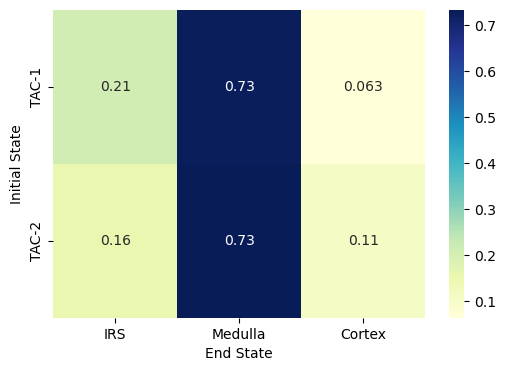

<Figure size 640x480 with 0 Axes>

In [11]:
import seaborn as sns
lambd = 0.1
# lambd = 4e-1

Gs = ot.sinkhorn(a, b, M, lambd)

prob_matrix = Gs

row_groups = np.array(Yi)  
column_groups = np.array(Yf)


row_group = np.unique(row_groups)
col_group = np.unique(column_groups)
num_row_groups = row_group.size
num_col_groups = col_group.size


agg_matrix = np.zeros((num_row_groups, num_col_groups))



# Aggregate probabilities
for i, rg in enumerate(row_group):
    for j, cg in enumerate(col_group):
        row_indices = np.where(row_groups == rg)[0]
        col_indices = [index for index, val in enumerate(column_groups) if val == cg]
        
        cell_sum = 0
        for ri in row_indices:
            for ci in col_indices:
#                 if ri < prob_matrix.shape[0] and ci < prob_matrix.shape[1]:
                    cell_sum += prob_matrix[ri, ci]
        
        # Assign the sum to the aggregated matrix cell
        agg_matrix[i, j] = cell_sum


## aggregate  

# Display the aggregated matrix



row_sums = agg_matrix.sum(axis=1, keepdims=True)
normalized_matrix = agg_matrix / row_sums

## normalize by column
# col_sums = agg_matrix.sum(axis=0, keepdims=True)
# normalized_matrix = agg_matrix / col_sums


normalized_matrix

row_names = ['TAC-1', 'TAC-2']
column_names = ['IRS', 'Medulla', 'Cortex']

# Visualize the row-normalized probability matrix with row names and column names
plt.figure(figsize=(6, 4))
sns.heatmap(normalized_matrix, annot=True, cmap='YlGnBu', 
            cbar=True, xticklabels=column_names, yticklabels=row_names)
# plt.title('Heatmap of Row-Normalized Probability Matrix with Row and Column Names')
plt.ylabel('Initial State')
plt.xlabel('End State')
plt.show()
plt.savefig("figs/Hair/20_aligned/OT_mvi.pdf", dpi=300)

In [12]:
normalized_matrix.flatten()

array([0.20889551, 0.72790312, 0.06320136, 0.15715887, 0.73403513,
       0.10880599])

In [13]:
ground_truth = [0, n_med / (n_irs + n_med), n_irs / (n_irs + n_med), 1, 0, 0]
ground_truth

[0, 0.486810551558753, 0.513189448441247, 1, 0, 0]

In [15]:
import scipy.stats as stats
stats.wasserstein_distance(normalized_matrix.flatten(), ground_truth)

0.18129330240949112

In [26]:
stats.wasserstein_distance([0.26, 0.53, 0.24, 0.86, 0.097, 0.04], ground_truth)

0.12677018385291766

In [16]:
## Benchmark GLUE
from complementary_models import HALOMASKVIR_ALN as HALOVI
HALOVI.setup_anndata(adata,time_key='latent_time')

glue = HALOVI(
    adata,
    n_genes=(adata.var['modality']=='Gene Expression').sum(),
    n_regions=(adata.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)
glue = glue.load("model_hair_align_nocausal_20", adata)


n_cats_per_cov None
INFO     File model_hair_align_nocausal_20/model.pt already downloaded                       
n_cats_per_cov None


In [17]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = glue.get_latent_representation()


In [23]:
adata.obsm["Xglue"]

array([[-0.5214951 , -2.3374243 ,  0.373846  , ..., -1.0736203 ,
         0.04271978, -0.71204007],
       [-0.8268375 , -2.7115831 ,  1.0326707 , ...,  0.3013251 ,
         0.12295788,  0.758625  ],
       [ 1.6212152 , -0.05909028, -0.04702962, ...,  2.6508775 ,
         0.27033818,  0.44280487],
       ...,
       [ 1.2446926 ,  0.66075593, -0.6380699 , ...,  1.2064087 ,
        -0.9833257 , -0.49294144],
       [-0.82352006,  1.2191306 , -1.6147867 , ..., -1.6711969 ,
         0.9545711 , -0.3335086 ],
       [ 0.82169837,  0.6715267 , -1.556605  , ..., -1.129025  ,
        -0.12190484, -0.83887523]], dtype=float32)

In [24]:
adata.obsm["Xglue"] = np.concatenate([latent_acc, latent_expr], axis=1)
adata_multi_ini  = adata[adata.obs['celltype'].isin( ['TAC-1', 'TAC-2'])].copy()
adata_multi_end = adata[adata.obs['celltype'].isin(['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])].copy()


Xi = adata_multi_ini.obsm["Xglue"]
Yi = adata_multi_ini.obs['celltype'].tolist()
umap_i = adata_multi_ini.obsm['X_umap']

Xf = adata_multi_end.obsm["Xglue"]
Yf = adata_multi_end.obs['celltype'].tolist()
umap_f = adata_multi_end.obsm['X_umap']

n1 = len(Xi)
n2 = len(Xf)

n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
n_tac2 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
adata_multi_ini.obs["prob"] = 0

adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)


n_irs = adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"].count()[0]
n_med = adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"].count()[0]
n_cort = adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"].count()[0]

adata_multi_end.obs["prob"] = 0

adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"]["prob"] = n_irs / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"]["prob"] = n_med / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"]["prob"] = n_cort / (n_irs + n_med+ n_cort)


a = adata_multi_ini.obs["prob"].to_list()
b = adata_multi_end.obs["prob"].to_list()


M = ot.dist(Xi, Xf,metric = 'sqeuclidean')


/tmp/ipykernel_5564/708137219.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
/tmp/ipykernel_5564/708137219.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)
/tmp/ipykernel_5564/708137219.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:477: RuntimeWarning: divide by zero encountered in true_divide
  Kp = (1 / a).reshape(-1, 1) * K
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:477: RuntimeWarning: invalid value encountered in multiply
  Kp = (1 / a).reshape(-1, 1) * K
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:484: RuntimeWarning: invalid value encountered in true_divide
  v = b / KtransposeU
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/tmp/ipykernel_5564/399707284.py:46: RuntimeWarning: invalid value encountered in true_divide
  normalized_matrix = agg_matrix / row_sums
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/haiyi/

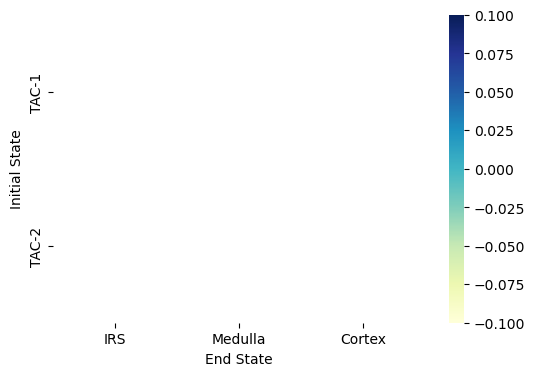

<Figure size 640x480 with 0 Axes>

In [25]:
import seaborn as sns
lambd = 0.05
# lambd = 4e-1

Gs = ot.sinkhorn(a, b, M, lambd)

prob_matrix = Gs

row_groups = np.array(Yi)  
column_groups = np.array(Yf)


row_group = np.unique(row_groups)
col_group = np.unique(column_groups)
num_row_groups = row_group.size
num_col_groups = col_group.size


agg_matrix = np.zeros((num_row_groups, num_col_groups))



# Aggregate probabilities
for i, rg in enumerate(row_group):
    for j, cg in enumerate(col_group):
        row_indices = np.where(row_groups == rg)[0]
        col_indices = [index for index, val in enumerate(column_groups) if val == cg]
        
        cell_sum = 0
        for ri in row_indices:
            for ci in col_indices:
#                 if ri < prob_matrix.shape[0] and ci < prob_matrix.shape[1]:
                    cell_sum += prob_matrix[ri, ci]
        
        # Assign the sum to the aggregated matrix cell
        agg_matrix[i, j] = cell_sum


## aggregate  

# Display the aggregated matrix



row_sums = agg_matrix.sum(axis=1, keepdims=True)
normalized_matrix = agg_matrix / row_sums

## normalize by column
# col_sums = agg_matrix.sum(axis=0, keepdims=True)
# normalized_matrix = agg_matrix / col_sums


normalized_matrix

row_names = ['TAC-1', 'TAC-2']
column_names = ['IRS', 'Medulla', 'Cortex']

# Visualize the row-normalized probability matrix with row names and column names
plt.figure(figsize=(6, 4))
sns.heatmap(normalized_matrix, annot=True, cmap='YlGnBu', 
            cbar=True, xticklabels=column_names, yticklabels=row_names)
# plt.title('Heatmap of Row-Normalized Probability Matrix with Row and Column Names')
plt.ylabel('Initial State')
plt.xlabel('End State')
plt.show()
plt.savefig("figs/Hair/20_aligned/OT_glue.pdf", dpi=300)

In [22]:
normalized_matrix

array([[nan, nan, nan],
       [nan, nan, nan]])

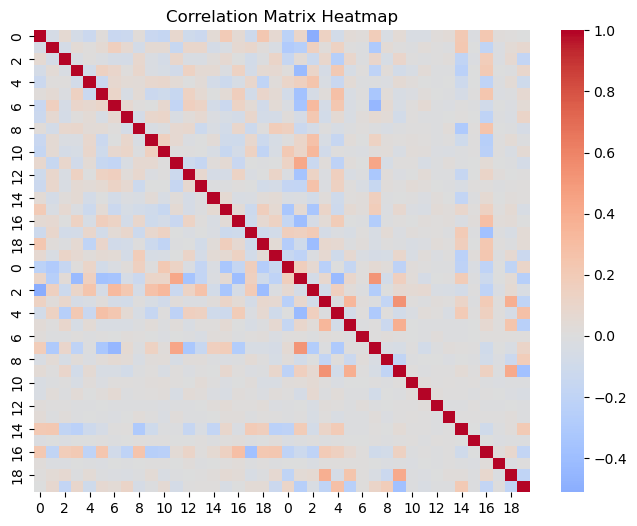

In [7]:
import pandas as pd
import seaborn as sns
df_1 = pd.DataFrame(latent_expr)
df_2 = pd.DataFrame(latent_acc)
df_combined = pd.concat([df_1, df_2],axis=1)
correlation_matrix = df_combined.corr()


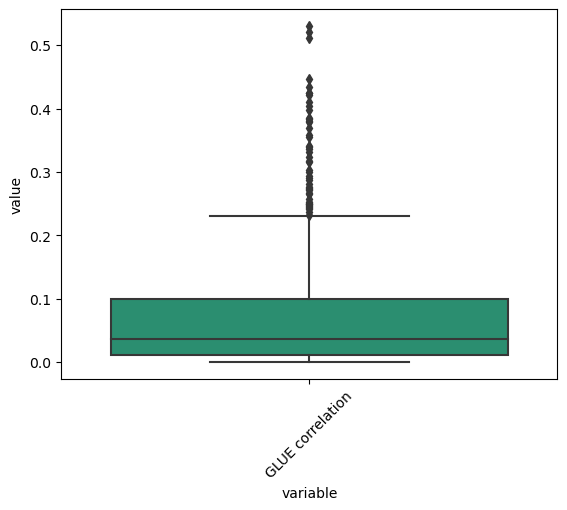

In [8]:
correlation_matrix = np.abs(correlation_matrix)
lower_triangular_matrix = np.tril(correlation_matrix, k=-1)
lower_diagonal_values = lower_triangular_matrix[lower_triangular_matrix != 0]
df = pd.DataFrame({"variable": "GLUE correlation", "value": lower_diagonal_values})
ax = sns.boxplot(x='variable', y='value', data=df, palette="Dark2")
plt.xticks(rotation=45)
plt.savefig("corr_glue_hair.pdf", dpi=300)

In [9]:
df.to_csv("hair_corr_glue.csv")

6


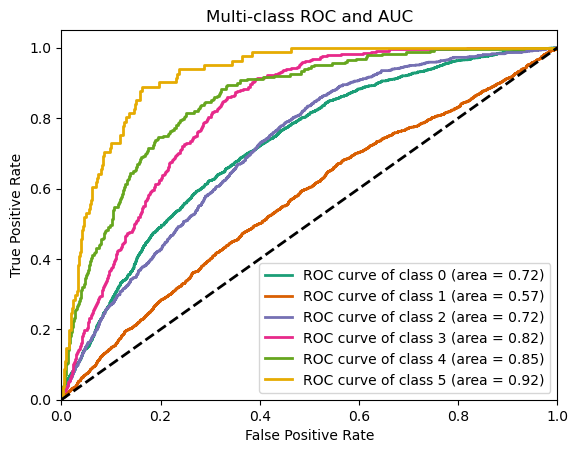

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc


X = df_combined.to_numpy()
bins = 6
y = pd.cut(adata.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
roc_df = pd.DataFrame({"fpr":fpr, "tpr": tpr, "roc_auc":roc_auc, "methods": "rna_atac_glue"})
plt.savefig("figs/Hair/20_aligned/glue_roc.pdf", dpi=300)


In [16]:
roc_df.to_csv("hair_glue_roc.csv")

In [3]:
## plot figures

### correlations compared with different methods

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [62]:
# pd4 =  pd.read_csv("Benchmark/hair_corr_mira.csv",index_col=0)
# pd4 = pd4[pd4['value'] < 0.8]
# pd4.to_csv("Benchmark/hair_corr_mira.csv")

# pd5 =  pd.read_csv("Benchmark/hair_corr_multiVI.csv",index_col=0)
# pd5 = pd5[pd5['value'] < 0.8]
# pd5.to_csv("Benchmark/hair_corr_multiVI.csv")


In [63]:
pd1 = pd.read_csv("Benchmark/hair_correlation_halo.csv",index_col=0)
pd1 = pd1[pd1["variable"].isin(["couple correlation", 'decouple correlation'])]
pd2 =  pd.read_csv("Benchmark/hair_corr_glue.csv",index_col=0)
pd3 =  pd.read_csv("Benchmark/hair_corr_scMVP.csv",index_col=0)
pd4 =  pd.read_csv("Benchmark/hair_corr_mira.csv",index_col=0)
pd5 =  pd.read_csv("Benchmark/hair_corr_multiVI.csv",index_col=0)
df = pd.concat([pd1, pd2, pd3, pd4, pd5], axis=0)
df["value"] = df["value"].abs()

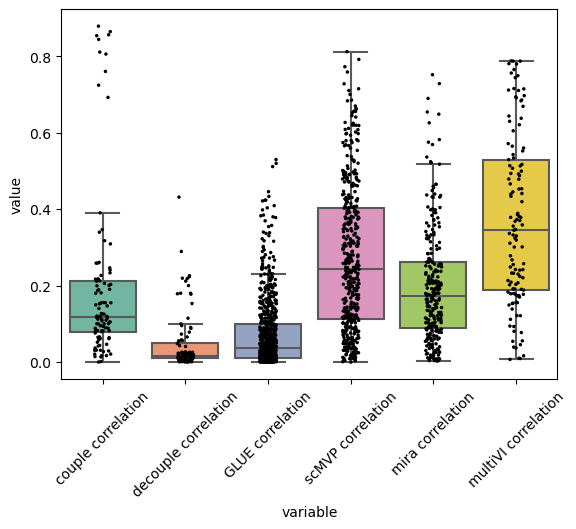

In [95]:
ax = sns.boxplot(x='variable', y='value', data=df, palette="Set2",  flierprops=dict(marker=' ', color='white', markersize=2))
sns.stripplot(x='variable', y='value', data=df, color='black', size=2.5, jitter=True)

plt.xticks(rotation=45)
plt.savefig("Benchmark/corr_hair.pdf", dpi=300)

In [106]:
pd1 = pd.read_csv("Benchmark/hair_halo_roc.csv",index_col=0)
pd1 = pd1[pd1["methods"]=="rna_atac_halo"]

pd2 =  pd.read_csv("Benchmark/hair_glue_roc.csv",index_col=0)
pd3 =  pd.read_csv("Benchmark/hair_scMVP_roc.csv",index_col=0)
pd4 =  pd.read_csv("Benchmark/hair_mira_roc.csv",index_col=0)
pd5 =  pd.read_csv("Benchmark/hair_multiVI_roc.csv",index_col=0)
df = pd.concat([pd1, pd4, pd2, pd5, pd3], axis=0)


<Axes.ArtistList of 0 artists>


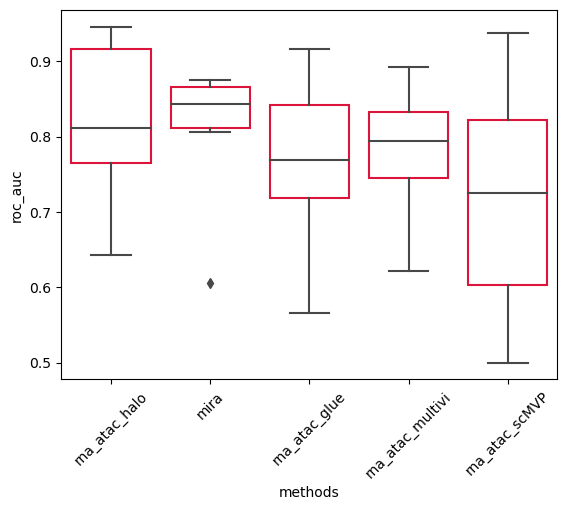

In [115]:
ax = sns.boxplot(x='methods', y='roc_auc', data=df, palette="Set1", boxprops=dict(facecolor='none', edgecolor = "crimson"))
colors = ['red', 'blue', 'green', 'orange', "pink"]
print(ax.artists)
for i, box in enumerate(ax.artists):
    box.set_edgecolor(colors[i])
plt.xticks(rotation=45)
plt.savefig("Benchmark/roc_hair.pdf", dpi=300)

In [27]:
## OT benchmark on 


rna_data = sc.read_h5ad("data/datasets/mouse_hair_mira_rna.h5ad")
atac_data = sc.read_h5ad("data/datasets/mouse_hair_mira_atac.h5ad")

In [32]:
rna_data

AnnData object with n_obs × n_vars = 6436 × 959
    obs: 'atac.bc', 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'model_read_scale', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13'
    var: 'feature_types', 'modality', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'exog', 'endog'
    uns: 'hvg', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_topic_compositions', 'X_umap'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'
    obsp:

In [35]:
features = np.concatenate([rna_data.obs[[ 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13']],
 atac_data.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5','topic_6', 'topic_7', 'topic_8']]], axis=1)
adata.obsm["Xmira"] = features
adata_multi_ini  = adata[adata.obs['celltype'].isin( ['TAC-1', 'TAC-2'])].copy()
adata_multi_end = adata[adata.obs['celltype'].isin(['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])].copy()


Xi = adata_multi_ini.obsm["Xmira"]
Yi = adata_multi_ini.obs['celltype'].tolist()
umap_i = adata_multi_ini.obsm['X_umap']

Xf = adata_multi_end.obsm["Xmira"]
Yf = adata_multi_end.obs['celltype'].tolist()
umap_f = adata_multi_end.obsm['X_umap']

n1 = len(Xi)
n2 = len(Xf)

n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
n_tac2 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
adata_multi_ini.obs["prob"] = 0

adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)


n_irs = adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"].count()[0]
n_med = adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"].count()[0]
n_cort = adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"].count()[0]

adata_multi_end.obs["prob"] = 0

adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"]["prob"] = n_irs / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"]["prob"] = n_med / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"]["prob"] = n_cort / (n_irs + n_med+ n_cort)


a = adata_multi_ini.obs["prob"].to_list()
b = adata_multi_end.obs["prob"].to_list()


M = ot.dist(Xi, Xf,metric = 'sqeuclidean')


/tmp/ipykernel_5564/2341183910.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
/tmp/ipykernel_5564/2341183910.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)
/tmp/ipykernel_5564/2341183910.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:477: RuntimeWarning: divide by zero encountered in true_divide
  Kp = (1 / a).reshape(-1, 1) * K
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


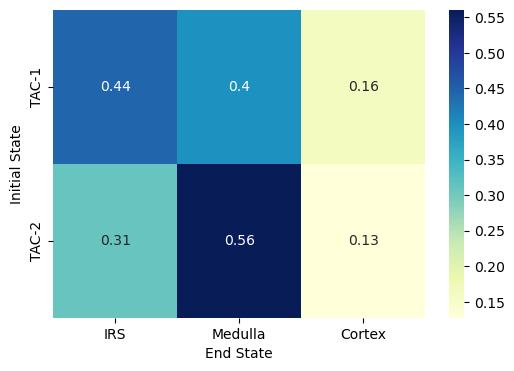

<Figure size 640x480 with 0 Axes>

In [36]:
lambd = 0.05
# lambd = 4e-1

Gs = ot.sinkhorn(a, b, M, lambd)

prob_matrix = Gs

row_groups = np.array(Yi)  
column_groups = np.array(Yf)


row_group = np.unique(row_groups)
col_group = np.unique(column_groups)
num_row_groups = row_group.size
num_col_groups = col_group.size


agg_matrix = np.zeros((num_row_groups, num_col_groups))



# Aggregate probabilities
for i, rg in enumerate(row_group):
    for j, cg in enumerate(col_group):
        row_indices = np.where(row_groups == rg)[0]
        col_indices = [index for index, val in enumerate(column_groups) if val == cg]
        
        cell_sum = 0
        for ri in row_indices:
            for ci in col_indices:
#                 if ri < prob_matrix.shape[0] and ci < prob_matrix.shape[1]:
                    cell_sum += prob_matrix[ri, ci]
        
        # Assign the sum to the aggregated matrix cell
        agg_matrix[i, j] = cell_sum


## aggregate  

# Display the aggregated matrix



row_sums = agg_matrix.sum(axis=1, keepdims=True)
normalized_matrix = agg_matrix / row_sums

## normalize by column
# col_sums = agg_matrix.sum(axis=0, keepdims=True)
# normalized_matrix = agg_matrix / col_sums


normalized_matrix

row_names = ['TAC-1', 'TAC-2']
column_names = ['IRS', 'Medulla', 'Cortex']

# Visualize the row-normalized probability matrix with row names and column names
plt.figure(figsize=(6, 4))
sns.heatmap(normalized_matrix, annot=True, cmap='YlGnBu', 
            cbar=True, xticklabels=column_names, yticklabels=row_names)
# plt.title('Heatmap of Row-Normalized Probability Matrix with Row and Column Names')
plt.ylabel('Initial State')
plt.xlabel('End State')
plt.show()
plt.savefig("figs/Hair/20_aligned/OT_mira.pdf", dpi=300)

In [37]:
stats.wasserstein_distance(normalized_matrix.flatten(), ground_truth)

0.1997844968997124

In [6]:
adata

AnnData object with n_obs × n_vars = 6436 × 113615
    obs: 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'chromepot', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'epxr_latent_10', 'epxr_latent_11', 'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15', 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 'atac_latent_11', 'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19'
    var: 'feature_types', 'modality', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap'
    obsm: 'X_mvi', 'X_scMVP', 'X_

In [9]:
# features = np.concatenate([rna_data.obs[[ 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13']],
#  atac_data.obs[['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5','topic_6', 'topic_7', 'topic_8']]], axis=1)
# adata.obsm["Xmira"] = features
import  ot
import ot.plot

adata_multi_ini  = adata[adata.obs['celltype'].isin( ['TAC-1', 'TAC-2'])].copy()
adata_multi_end = adata[adata.obs['celltype'].isin(['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])].copy()


Xi = adata_multi_ini.obsm["X_scMVP"]
Yi = adata_multi_ini.obs['celltype'].tolist()
umap_i = adata_multi_ini.obsm['X_umap']

Xf = adata_multi_end.obsm["X_scMVP"]
Yf = adata_multi_end.obs['celltype'].tolist()
umap_f = adata_multi_end.obsm['X_umap']

n1 = len(Xi)
n2 = len(Xf)

n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
n_tac2 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
adata_multi_ini.obs["prob"] = 0

adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)


n_irs = adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"].count()[0]
n_med = adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"].count()[0]
n_cort = adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"].count()[0]

adata_multi_end.obs["prob"] = 0

adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"]["prob"] = n_irs / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"]["prob"] = n_med / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"]["prob"] = n_cort / (n_irs + n_med+ n_cort)


a = adata_multi_ini.obs["prob"].to_list()
b = adata_multi_end.obs["prob"].to_list()


M = ot.dist(Xi, Xf,metric = 'sqeuclidean')

/tmp/ipykernel_13271/1656536267.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
/tmp/ipykernel_13271/1656536267.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)
/tmp/ipykernel_13271/1656536267.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:477: RuntimeWarning: divide by zero encountered in true_divide
  Kp = (1 / a).reshape(-1, 1) * K
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:477: RuntimeWarning: invalid value encountered in multiply
  Kp = (1 / a).reshape(-1, 1) * K
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


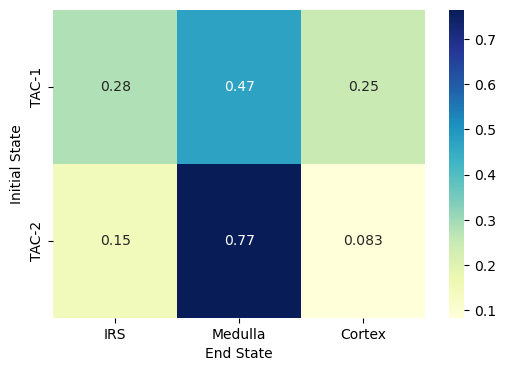

<Figure size 640x480 with 0 Axes>

In [17]:
lambd = 0.1
# lambd = 4e-1
import seaborn as sns
Gs = ot.sinkhorn(a, b, M, lambd)

prob_matrix = Gs

row_groups = np.array(Yi)  
column_groups = np.array(Yf)


row_group = np.unique(row_groups)
col_group = np.unique(column_groups)
num_row_groups = row_group.size
num_col_groups = col_group.size


agg_matrix = np.zeros((num_row_groups, num_col_groups))



# Aggregate probabilities
for i, rg in enumerate(row_group):
    for j, cg in enumerate(col_group):
        row_indices = np.where(row_groups == rg)[0]
        col_indices = [index for index, val in enumerate(column_groups) if val == cg]
        
        cell_sum = 0
        for ri in row_indices:
            for ci in col_indices:
#                 if ri < prob_matrix.shape[0] and ci < prob_matrix.shape[1]:
                    cell_sum += prob_matrix[ri, ci]
        
        # Assign the sum to the aggregated matrix cell
        agg_matrix[i, j] = cell_sum


## aggregate  

# Display the aggregated matrix



row_sums = agg_matrix.sum(axis=1, keepdims=True)
normalized_matrix = agg_matrix / row_sums

## normalize by column
# col_sums = agg_matrix.sum(axis=0, keepdims=True)
# normalized_matrix = agg_matrix / col_sums


normalized_matrix

row_names = ['TAC-1', 'TAC-2']
column_names = ['IRS', 'Medulla', 'Cortex']

# Visualize the row-normalized probability matrix with row names and column names
plt.figure(figsize=(6, 4))
sns.heatmap(normalized_matrix, annot=True, cmap='YlGnBu', 
            cbar=True, xticklabels=column_names, yticklabels=row_names)
# plt.title('Heatmap of Row-Normalized Probability Matrix with Row and Column Names')
plt.ylabel('Initial State')
plt.xlabel('End State')
plt.savefig("figs/Hair/20_aligned/OT_scMVP.pdf", dpi=300)

In [18]:
import scipy.stats as stats
ground_truth = [0, n_med / (n_irs + n_med), n_irs / (n_irs + n_med), 1, 0, 0]

stats.wasserstein_distance(normalized_matrix.flatten(), ground_truth)

0.16026789059748603

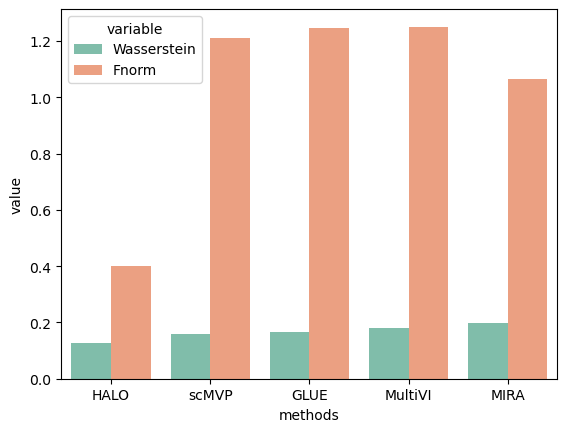

In [52]:
import pandas as pd
wd = pd.DataFrame({"methods":["HALO", "scMVP", "GLUE", "MultiVI", "MIRA"], "Wasserstein":[0.126770184, 0.160267891, 0.16687,0.181293302,0.199784497], "Fnorm":[0.4000085039049694, 1.2125346512221897, 1.246242, 1.2511113964585403, 1.064179899430621]})
wd = wd.melt(value_vars=["Wasserstein", "Fnorm"], id_vars="methods")
wd
ax = sns.barplot(x='methods', y='value', data=wd, palette="Set2", alpha=0.9, hue="variable")
new_width = 0.5

# Adjust bar width and position
# for bar in ax.patches:
#     x = bar.get_x()
#     width = bar.get_width()
#     centre = x + width / 2.
#     bar.set_width(new_width)
#     bar.set_x(centre - new_width / 2.)

# # Get the current axis
# ax = plt.gca()

# # Get bar width (there's a bit of a workaround since Seaborn doesn't expose bar width directly)
# bar_width = [rect.get_width() for rect in ax.patches][0]

# # Interpolate points - get the center of each bar
# # x_interpolated = np.arange(len(wd['methods'])) + bar_width / 2
# x_interpolated = np.arange(len(wd['methods'])) 

# # Draw lines connecting the bars
# plt.plot(x_interpolated, wd['Wasserstein'], color='pink', marker='o', linestyle='-', linewidth=2)

# plt.show()
# plt.savefig("Benchmark/Was_DIst.png", dpi=300)
# plt.savefig("Benchmark/Was_DIst.pdf", format="pdf", dpi=300)


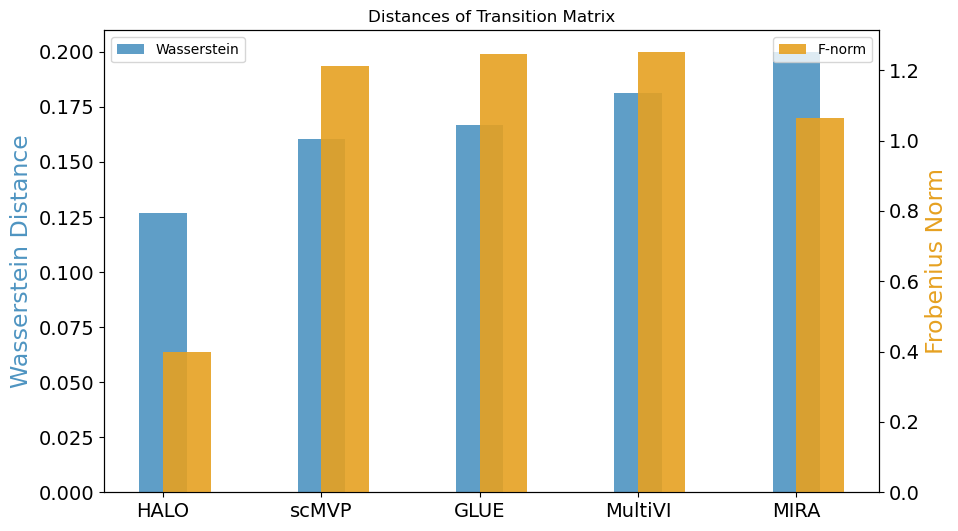

In [94]:
fig, ax1 = plt.subplots(figsize=(10, 6))

wd = pd.DataFrame({"methods":["HALO", "scMVP", "GLUE", "MultiVI", "MIRA"], "Wasserstein":[0.126770184, 0.160267891, 0.16687,0.181293302, 0.199784497], "Fnorm":[0.4000085039049694, 1.2125346512221897, 1.246242, 1.2511113964585403, 1.064179899430621]})

# Plot the first set of data with bars
bars1 = ax1.bar(wd['methods'], wd['Wasserstein'], color='#4E94C1', label='Wasserstein', alpha=0.9, width=0.3)
plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes

# Create the second y-axis based on the first
ax2 = ax1.twinx()

# Plot the second set of data with bars, offsetting the x positions to avoid overlap
x_offset = 0.2  # Adjust as necessary for your data and visual preferences
bars2 = ax2.bar(wd['methods'], wd['Fnorm'], width=0.3, color='#E6A121', alpha=0.9, label='F-norm', align='edge')

# Set the y-axis labels
ax1.set_ylabel('Wasserstein Distance', color='#4E94C1',size=17)
ax2.set_ylabel('Frobenius Norm', color='#E6A121',size=17)
plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes

# Optionally, set the title and legend
plt.title('Distances of Transition Matrix')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig("Benchmark/Dist.pdf", format="pdf", dpi=300)
# plt.savefig("Benchmark/Dist.png", format="png", dpi=300)


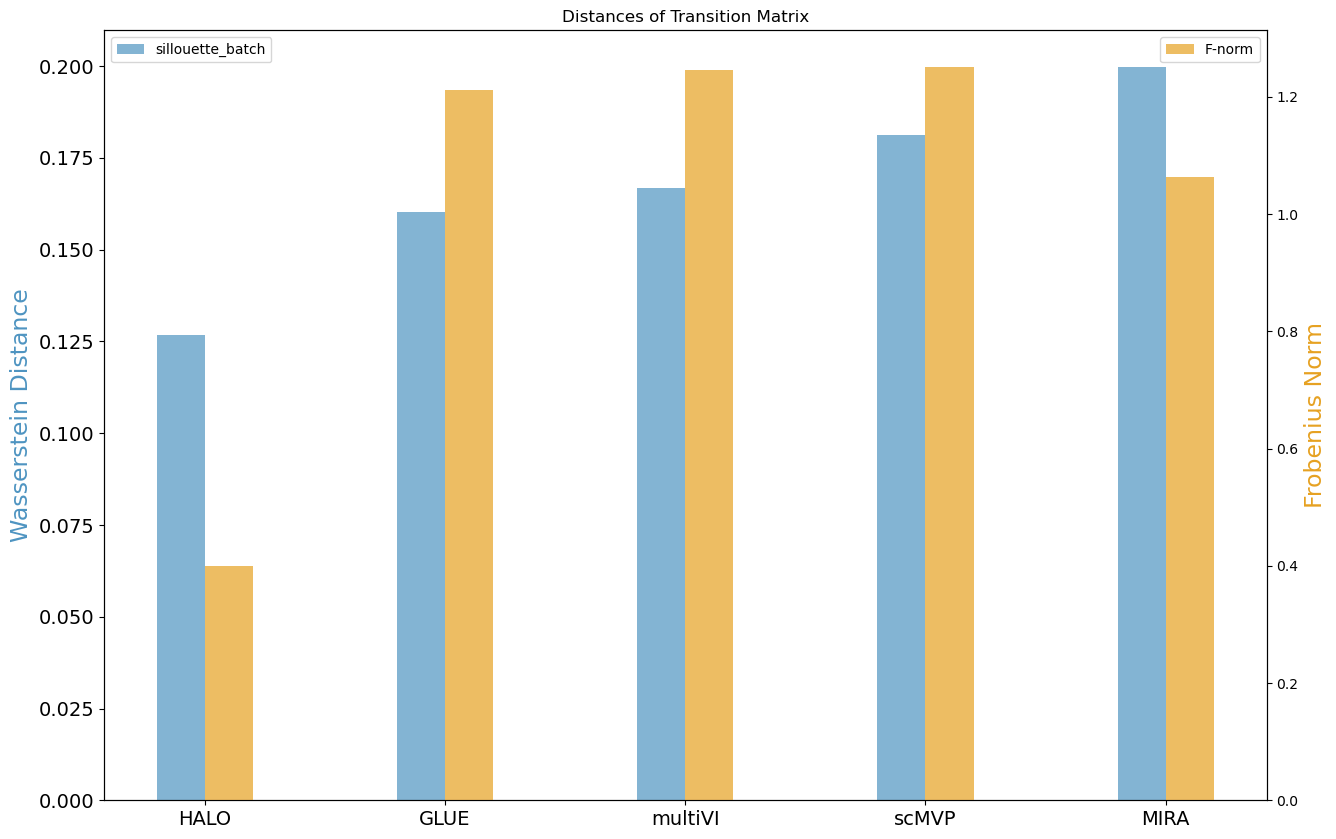

In [7]:
wd = pd.DataFrame({"methods":["HALO", "scMVP", "GLUE", "MultiVI", "MIRA"], "Wasserstein":[0.126770184, 0.160267891, 0.16687,0.181293302, 0.199784497], "Fnorm":[0.4000085039049694, 1.2125346512221897, 1.246242, 1.2511113964585403, 1.064179899430621]})


N = len(["HALO", "scMVP", "GLUE", "MultiVI", "MIRA"])
ind = np.arange(N)  

fig, ax1 = plt.subplots(figsize=(15, 10))
width = 0.2

# Plot the first set of data with bars
bars1 = ax1.bar(ind - width/2, wd['Wasserstein'], color='#4E94C1', label='sillouette_batch', alpha=0.7, width=width)
plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes

# Create the second y-axis based on the first
ax2 = ax1.twinx()

# Plot the second set of data with bars, offsetting the x positions to avoid overlap
# x_offset = 0.2  # Adjust as necessary for your data and visual preferences
bars2 = ax2.bar(ind, wd['Fnorm'], width=width, color='#E6A121', alpha=0.7, label='F-norm', align='edge')
ax1.set_xticks(ind)  # Set x-tick positions
ax1.set_xticklabels(["HALO", "GLUE", "multiVI", "scMVP", "MIRA"])
# Set the y-axis labels
ax1.set_ylabel('Wasserstein Distance', color='#4E94C1',size=17)
ax2.set_ylabel('Frobenius Norm', color='#E6A121',size=17)
# plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes
# ax2.set_xticklabels(mehotds)
# ax1.set_xticklabels(wd["methods"])
# plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes

# Optionally, set the title and legend
# plt.title('Batch Correction')

# # Plot the first set of data with bars
# bars1 = ax1.bar(wd['methods'], wd['Wasserstein'], color='#4E94C1', label='Wasserstein', alpha=0.9, width=0.3)
# plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes

# # Create the second y-axis based on the first
# ax2 = ax1.twinx()

# # Plot the second set of data with bars, offsetting the x positions to avoid overlap
# x_offset = 0.2  # Adjust as necessary for your data and visual preferences
# bars2 = ax2.bar(wd['methods'], wd['Fnorm'], width=0.3, color='#E6A121', alpha=0.9, label='F-norm', align='edge')

# # Set the y-axis labels
# ax1.set_ylabel('Wasserstein Distance', color='#4E94C1',size=17)
# ax2.set_ylabel('Frobenius Norm', color='#E6A121',size=17)
# plt.tick_params(axis='both', which='major', labelsize=14)  # 'both' applies changes to both axes

# # Optionally, set the title and legend
plt.title('Distances of Transition Matrix')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.savefig("Benchmark/Dist.pdf", format="pdf", dpi=300)